In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting with box-refinement & shifting boxes

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller
* check on the limits of time between adjacent clusters, esp. when they have the same mean and/or median
    * if at $x_a$ for $t_1$ then again at $x_a$ for $t_2$, duration between going from and back to $x_a$ should reflect some mimimal amount of time ($2\times$ travel and a stay), 
        * e.g. 
            * from $x_a$ to an unknown $x_b$ with a stay at $x_b$ of the miminum duration and then back to $x_a$ 
            * should satisfy some criterion or _there is no inbetween travel and $t_1$ and $t_2$ are part of the same cluster_
* check of the metrics for inter-subcluster gaps
    * these are also clusters but unlabeled after the first round of clustering

## Notes: 

* **Gaps** 
    * since there are subclusters for a given cluster which are separated by gaps, these gaps ...

### 1-stay
* gap-merging works well when good density; poorly when otherwise

## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.



In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [451]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [453]:
from synthetic_data.canonical_stays import get1, get2, get3e, get3, get3_core, gen_stays

In [430]:
time_thresh = 1/6
dist_thresh=0.25

In [431]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

In [433]:
from helper__metric_box__explore import iqr_metrics, get_boxplot_quants, get_clusters_rev, get_boxplot_centers, get_iqr_mask

In [428]:
get_2_stays = lambda n: 11.4*np.random.rand(n) - 5.7

10
14


<Figure size 1440x720 with 0 Axes>

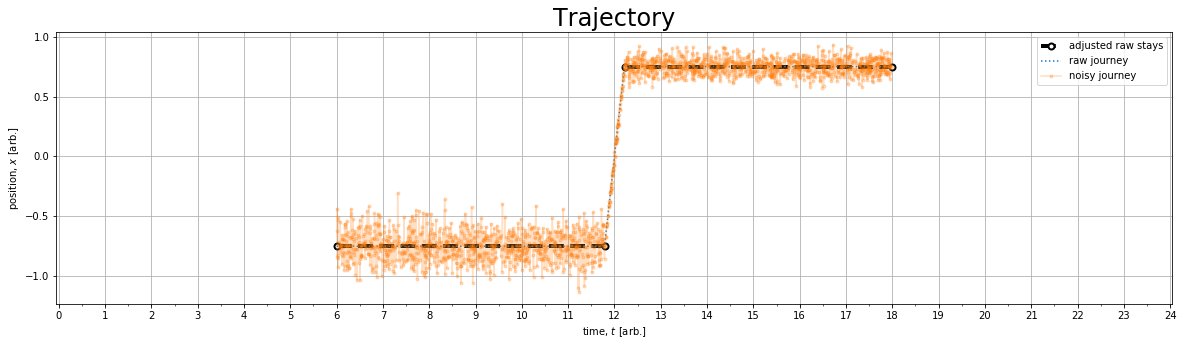

In [565]:
event_frac = 0.05 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}

stays = get2(0, -1.5)
#stays = get1()

time_arr, raw_arr, noise_arr, segments = get_trajectory(stays, t_total, configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

clusters = get_clusters(time_arr, noise_arr, dist_thresh, time_thresh)
print(len(clusters))

clusters_rev = get_clusters_rev(time_arr[::-1], noise_arr[::-1], dist_thresh, time_thresh)
print(len(clusters_rev))

plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

### IQR-plotting

For each sub-cluster, plot the quantile boxes with whistkers.

**Notes**
* the boxes usually capture the baseline of the underlying stay
* the forward and backward clusters
    * usually the same clusters in the stays with similar IQRs
    * usually different in the 

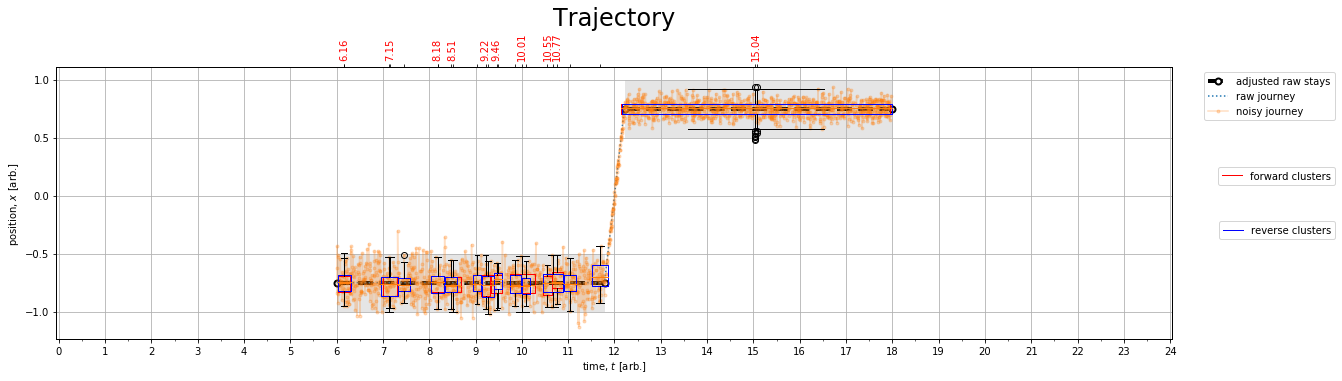

In [566]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr[::-1], noise_arr[::-1], clusters_rev)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [567]:
from helper__metric_box__explore import eval_synth_data

In [568]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.989
 0.721
[[  66   17]
 [ 571 1476]]

backward
 0.987
 0.800
[[  62   21]
 [ 410 1637]]


## Development

In [438]:
from helper__gaps import merge_clusters

In [439]:
from helper__metric_box__explore import get_cluster_boxplot, kwargs_filled, kwargs_unfilled

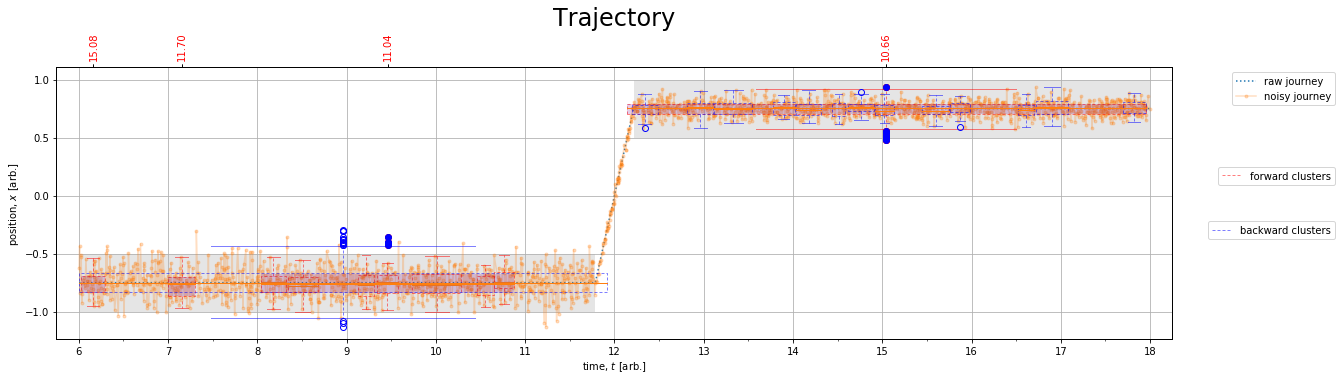

In [569]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, 3*time_thresh)
axt = get_cluster_boxplot(new_clusters, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_rev = merge_clusters(time_arr, noise_arr, clusters, dist_thresh, 3*time_thresh)
axt = get_cluster_boxplot(new_clusters_rev, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [570]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print('forward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)
print()
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters_rev)
print('backward')
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

forward
 0.990
 0.794
[[  66   17]
 [ 421 1626]]

backward
 0.990
 0.794
[[  66   17]
 [ 421 1626]]


Let stat. metric be $\bar{x}_i$ for $\mathrm{cluster}_i$'s location for $i=1,2$,
<br/>
and $d(\bar{x}_1,\bar{x}_2) < \delta$
<br/>
and $t_1$ is the last timepoint of $\mathrm{cluster}_1$ and $t_2$ is the first for $\mathrm{cluster}_2$,

Then, for all $t\in[t_1,t_2]$, $\exists$ an $\bar{x}$ $\$$ 
1. the duration of $\Delta t := t_2-t_1 \geq \tau$ + travel time with minimum velocity $v = 3.5$ km/hr
    * e.g. let $\bar{x}_1 = \bar{x}_2$ and $d(\bar{x}_1,\bar{x}) = 2\delta$,
    then, the overall duration $\Delta t = 2\cdot 2\delta/v + \tau$
    * specifically: $\bar{x}_1 = 0$, $d(\bar{x}_1,\bar{x}) = 2$km, then $\Delta t \geq 1.31$hr
2. $d(\bar{x}_1,\bar{x}) < \delta$ and $d(\bar{x},\bar{x}_2) < \delta$


In [555]:
from helper__gaps import get_gap_dist, get_gap_time

def get_intercluster_metrics(c1, c2, t_arr, x_arr, time_thresh, min_speed=3.6):

    clust = list(range(c1[-1],c2[0]+1))
    
    #t_sub = t_arr[clust]
    #x_sub = x_arr[clust]
    x_med = np.median(x_arr[clust])
    
    gap_time = get_gap_time(t_arr,c1,c2)
    
    gap_d1 = get_gap_dist(x_arr,c1,clust)
    gap_d2 = get_gap_dist(x_arr,c2,clust)
    
    dur1 = gap_d1/min_speed
    dur2 = gap_d2/min_speed
    
    return gap_time, dur1+dur2+time_thresh, x_med
    

In [558]:
for c1,c2 in zip(clusters[:-1],clusters[1:]):
    
    gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh, 3.4)
    
    print(f"{gap_time:5.3f}, {min_allowed:5.3f}", 
          gap_time < min_allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

0.242, 0.176 False 	 -1.718  -1.723  -1.748 	  0.005   0.025
0.872, 0.184 False 	 -1.748  -1.758  -1.711 	  0.010   0.047
0.046, 0.246 True 	 -1.711  -1.610  -1.778 	  0.101   0.168
0.198, 0.179 False 	 -1.778  -1.746  -1.755 	  0.032   0.009
0.299, 0.176 False 	 -1.755  -1.732  -1.741 	  0.023   0.009
0.393, 0.168 False 	 -1.741  -1.743  -1.745 	  0.002   0.002
0.235, 0.184 False 	 -1.745  -1.783  -1.803 	  0.038   0.020
0.299, 0.210 False 	 -1.803  -1.728  -1.801 	  0.075   0.073
0.029, 0.195 True 	 -1.801  -1.714  -1.724 	  0.086   0.010
1.025, 1.192 True 	 -1.724   0.143   1.762 	  1.867   1.619
0.030, 0.176 True 	  1.762   1.737   1.742 	  0.025   0.005
0.143, 0.174 True 	  1.742   1.764   1.759 	  0.022   0.004
0.003, 0.227 True 	  1.759   1.680   1.806 	  0.080   0.126


In [560]:
def gap_criterion_2(dist_thresh, time_thresh, min_speed=3.5):
    
    def meth(t_arr, x_arr, c1, c2):
        
        gap_time, min_allowed, x_med = get_intercluster_metrics(c1, c2, t_arr, x_arr, time_thresh)
        
        # if gap_time is less than allowed time for a recognizeable travel-stay-travel, mark for a merge
        # otherwise if the gap is large enough and the medians are near enough, mark for a merge
        if (gap_time < min_allowed) & \
           ((abs(np.median(x_arr[c1]) - x_med) < dist_thresh) & 
            (abs(np.median(x_arr[c2]) - x_med) < dist_thresh)):
            return True
        elif ((abs(np.median(x_arr[c1]) - x_med) < dist_thresh) & 
              (abs(np.median(x_arr[c2]) - x_med) < dist_thresh)):
            return True
        else:
            return False
    
    return meth

In [550]:
from helper__gaps import merge_cluster_pair

In [571]:
[gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(clusters[:-1],clusters[1:])]

[True, True, True, True, True, True, True, True, False]

In [562]:
def merge_clusters_2(t_arr, x_arr, clusters, dist_thresh, time_thresh, min_speed=3.5, verbose=False):
    """
    Iteratively merge clusters in a a list according to criteria regarding the gaps between them
    """
    
    new_clusters = clusters.copy()
    
    gaps = [gap_criterion_2(dist_thresh, time_thresh)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]
    
    while any(gaps):
        
        dists = [get_gap_dist(x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]

        gaps_add = np.array([100*int(not g) for g in gaps])
        dists_add = np.array(dists)+gaps_add

        min_index = np.argmin(dists_add)
        
        if verbose: print(gaps, "\n", [f"{d:5.3f}" for d in dists], "\n", min_index)
        
        new_clusters = merge_cluster_pair(new_clusters, min_index).copy()
        
        gaps = [gap_criterion_2(dist_thresh, time_thresh)(t_arr,x_arr,c1,c2) for c1, c2 in zip(new_clusters[:-1],new_clusters[1:])]        

    if verbose: print(gaps)
    
    return new_clusters

In [572]:
new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh, 3.5, True)

[True, True, True, True, True, True, True, True, False] 
 ['0.014', '0.016', '0.028', '0.003', '0.025', '0.025', '0.017', '0.014', '1.494'] 
 3
[True, True, True, True, True, True, True, False] 
 ['0.014', '0.016', '0.016', '0.015', '0.025', '0.017', '0.014', '1.494'] 
 6
[True, True, True, True, True, True, False] 
 ['0.014', '0.016', '0.016', '0.015', '0.025', '0.025', '1.499'] 
 0
[True, True, True, True, True, False] 
 ['0.000', '0.016', '0.015', '0.025', '0.025', '1.499'] 
 0
[True, True, True, True, False] 
 ['0.014', '0.015', '0.025', '0.025', '1.499'] 
 0
[True, True, True, False] 
 ['0.003', '0.025', '0.025', '1.499'] 
 0
[True, True, False] 
 ['0.022', '0.025', '1.499'] 
 0
[True, False] 
 ['0.006', '1.499'] 
 0
[False]


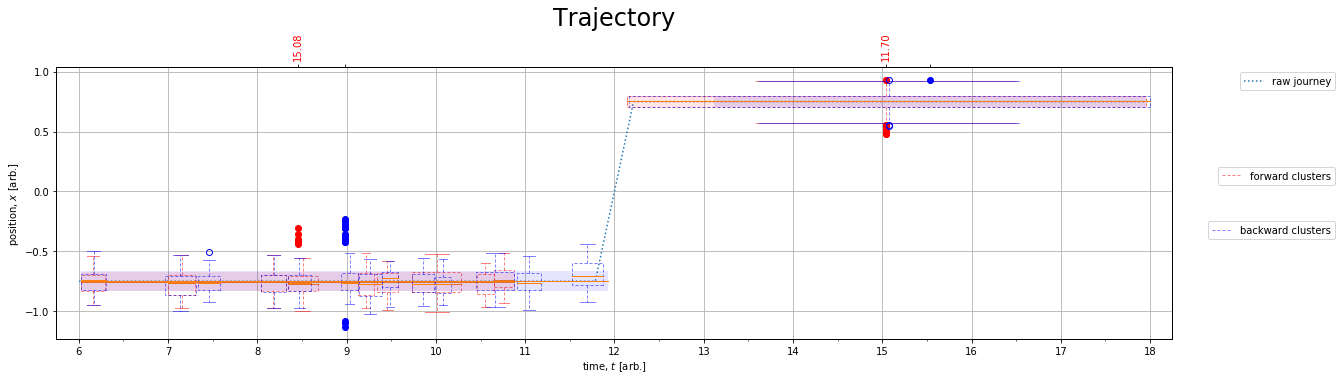

In [581]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

ax.set_xlim([5.75,18.25])

axt = ax.twiny()

kwargs_unfilled['color'] = 'red'
kwargs_unfilled['legend_label'] = 'forward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.6)

kwargs_filled['color'] = 'red'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.6)

axt = get_cluster_boxplot(clusters, time_arr, noise_arr, axt, **kwargs_unfilled)

new_clusters_2 = merge_clusters_2(time_arr, noise_arr, clusters, dist_thresh, time_thresh)
axt = get_cluster_boxplot(new_clusters_2, time_arr, noise_arr, axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')
axt.set_xlim(ax.get_xlim())


axt = ax.twiny()

kwargs_unfilled['color'] = 'blue'
kwargs_unfilled['legend_label'] = 'backward clusters'
kwargs_unfilled['bbox_tuple'] = (1.15, 0.4)

kwargs_filled['color'] = 'blue'
kwargs_filled['legend_label'] = None
kwargs_filled['bbox_tuple'] = (1.15, 0.4)

axt = get_cluster_boxplot(clusters_rev, time_arr[::-1], noise_arr[::-1], axt, **kwargs_unfilled)
new_clusters_rev_2 = merge_clusters_2(time_arr[::-1], noise_arr[::-1], clusters, dist_thresh, time_thresh)
axt = get_cluster_boxplot(new_clusters_rev_2, time_arr[::-1], noise_arr[::-1], axt, **kwargs_filled)

for label in axt.get_xticklabels():
    label.set_rotation(90)    
axt.set_xticklabels(labels, visible=False)
axt.set_xlim(ax.get_xlim())


ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

0.242, 0.175 True 	 -1.718  -1.723  -1.748 	  0.005   0.025
0.872, 0.183 True 	 -1.748  -1.758  -1.711 	  0.010   0.047
0.046, 0.244 False 	 -1.711  -1.610  -1.778 	  0.101   0.168
0.198, 0.178 True 	 -1.778  -1.746  -1.755 	  0.032   0.009
0.299, 0.176 True 	 -1.755  -1.732  -1.741 	  0.023   0.009
0.393, 0.168 True 	 -1.741  -1.743  -1.745 	  0.002   0.002
0.235, 0.184 True 	 -1.745  -1.783  -1.760 	  0.038   0.023
0.029, 0.183 False 	 -1.760  -1.714  -1.724 	  0.046   0.010
1.025, 1.163 False 	 -1.724   0.143   1.762 	  1.867   1.619
0.030, 0.175 False 	  1.762   1.737   1.742 	  0.025   0.005
0.143, 0.174 False 	  1.742   1.764   1.759 	  0.022   0.004
0.003, 0.226 False 	  1.759   1.680   1.806 	  0.080   0.126



0.242, 0.175 True 	 -1.718  -1.723  -1.748 	  0.005   0.025
0.872, 0.183 True 	 -1.748  -1.758  -1.711 	  0.010   0.047
0.046, 0.244 False 	 -1.711  -1.610  -1.778 	  0.101   0.168
0.198, 0.178 True 	 -1.778  -1.746  -1.755 	  0.032   0.009
0.299, 0.176 True 	 -1.755  -1

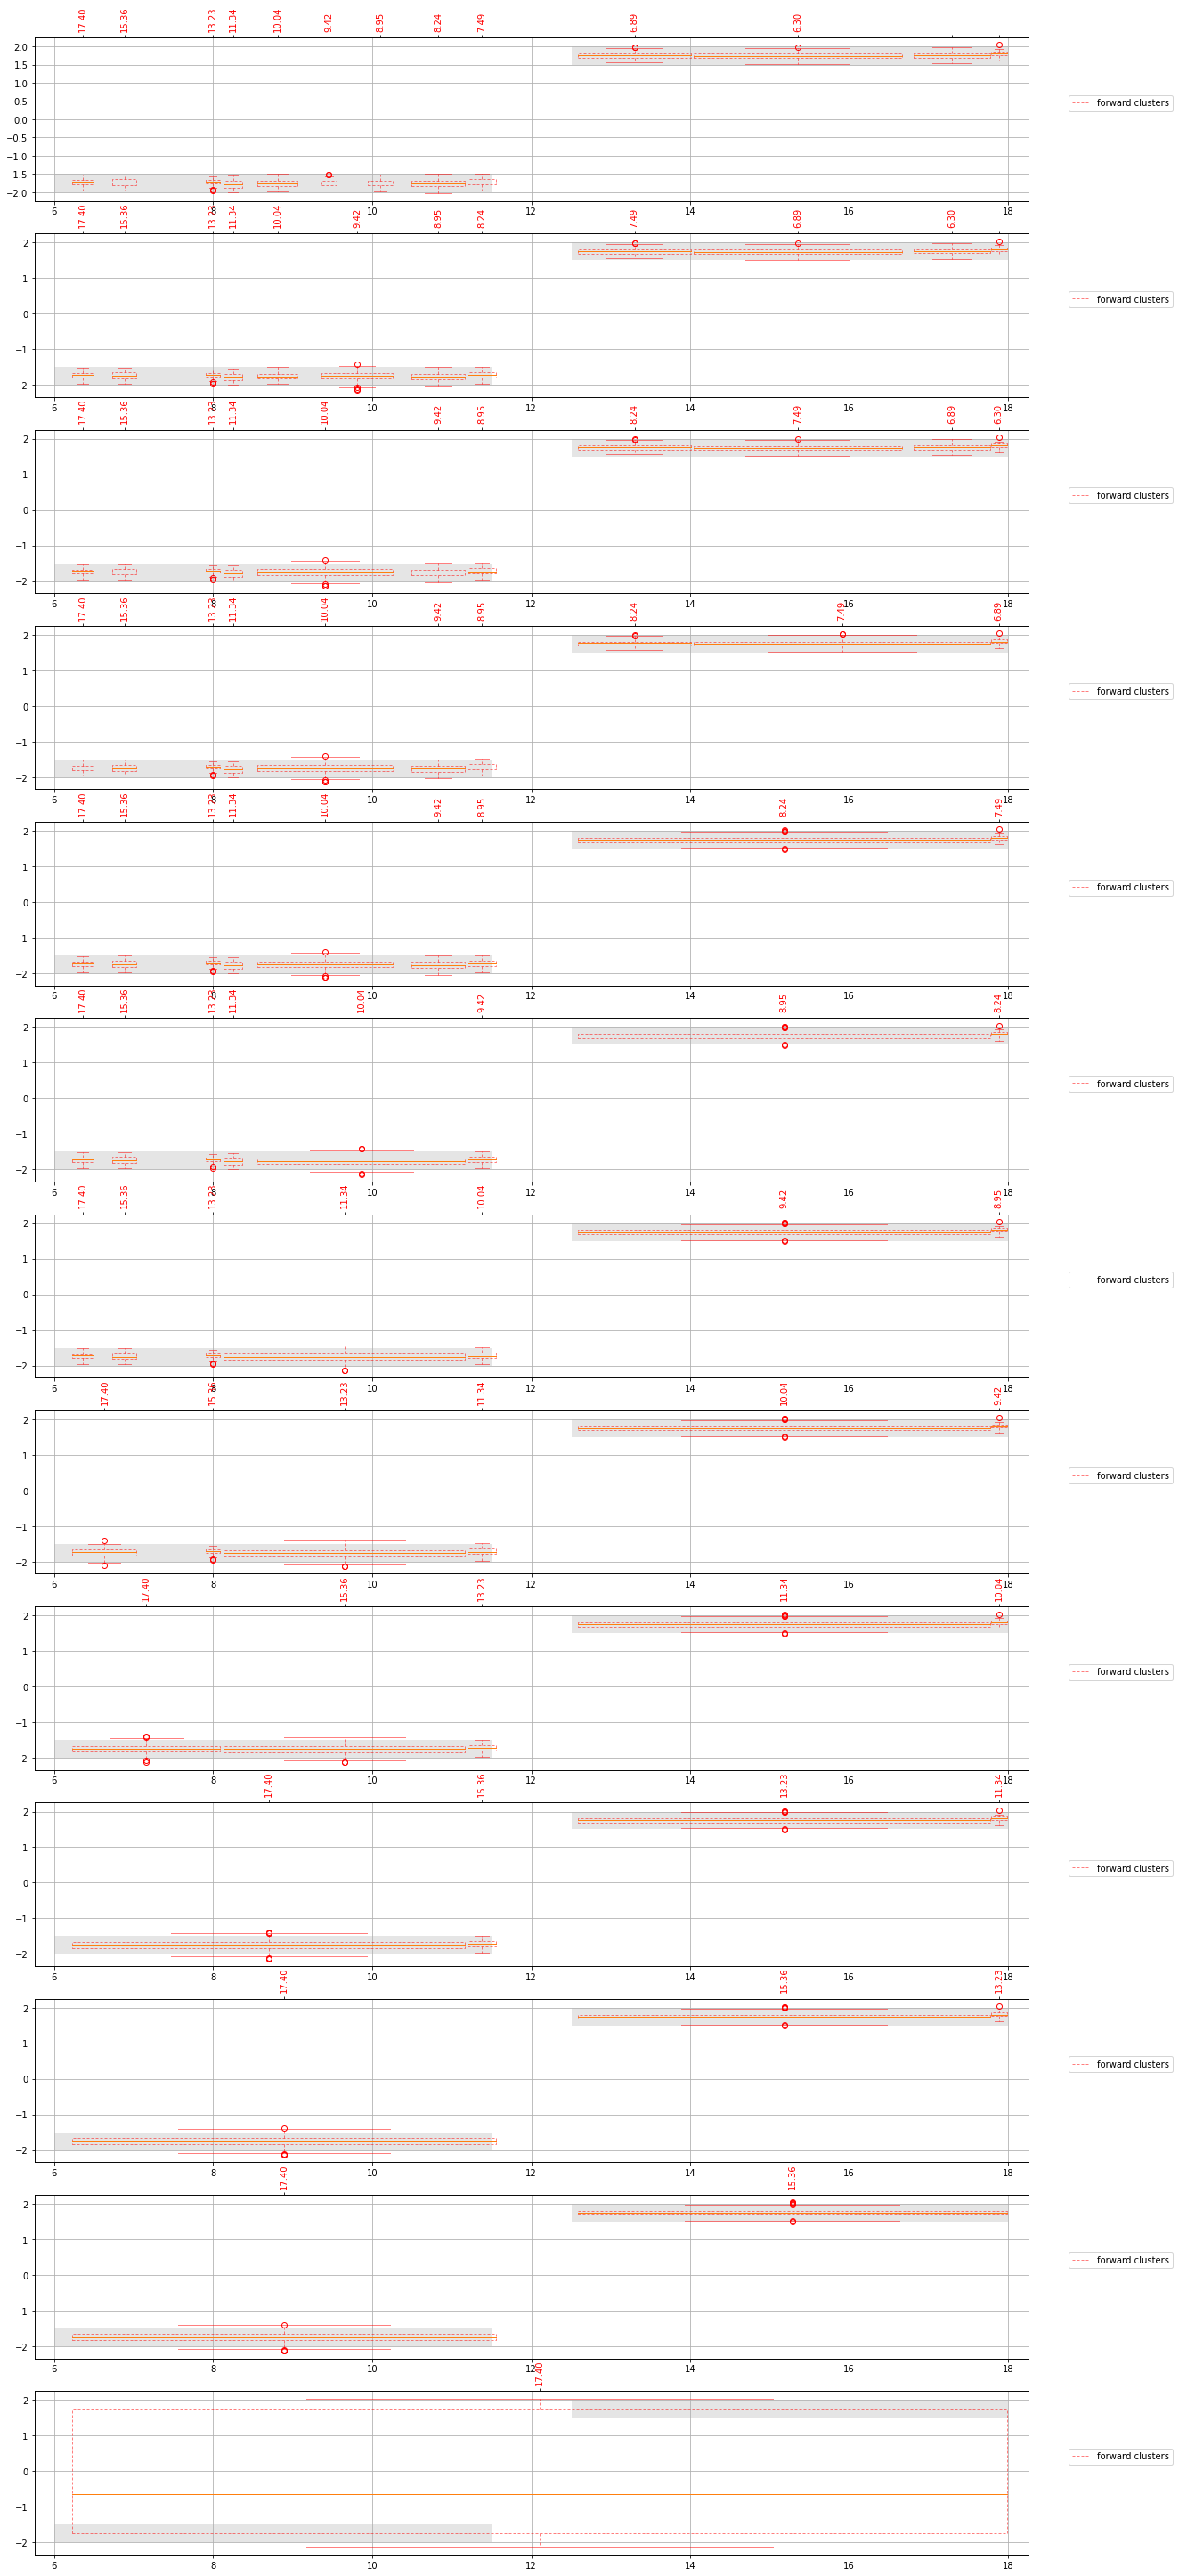

In [543]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters2 = clusters.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])

    axt = ax.twiny()

    gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]     
    dists = [get_gap_dist(noise_arr,c1,c2) for c1, c2 in zip(new_clusters2[:-1],new_clusters2[1:])]

    gaps_add = np.array([100*int(not g) for g in gaps])
    dists_add = np.array(dists)+gaps_add

    min_index = np.argmin(dists_add)

    new_clusters2 = merge_cluster_pair(new_clusters2, min_index).copy()
    
    for c1,c2 in zip(new_clusters2[:-1],new_clusters2[1:]):

        gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh)

        print(f"{gtime:5.3f}, {allowed:5.3f}", 
              gtime>allowed, 
              f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}",
              f"\t{abs(np.median(noise_arr[c1] - x_med)):7.3f} {abs(np.median(noise_arr[c2] - x_med)):7.3f}")
    print('\n\n')   
    axt = get_cluster_boxplot(new_clusters2, time_arr, noise_arr, axt, **kwargs_unfilled)


    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')
    axt.set_xlim(ax.get_xlim())

    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    


0.288, 0.571 False 	  0.752   0.067  -0.702 	  0.685   0.769
0.348, 0.184 True 	 -0.702  -0.752  -0.764 	  0.050   0.012
0.027, 0.218 False 	 -0.764  -0.664  -0.749 	  0.101   0.085
0.276, 0.178 True 	 -0.749  -0.741  -0.775 	  0.008   0.034
0.158, 0.182 False 	 -0.775  -0.770  -0.719 	  0.005   0.051
0.001, 0.236 False 	 -0.719  -0.870  -0.771 	  0.151   0.099
0.007, 0.176 False 	 -0.771  -0.750  -0.764 	  0.021   0.013
0.340, 0.180 True 	 -0.764  -0.742  -0.768 	  0.022   0.027
0.016, 0.199 False 	 -0.768  -0.816  -0.747 	  0.048   0.069
0.455, 0.172 True 	 -0.747  -0.760  -0.767 	  0.013   0.007
0.018, 0.247 False 	 -0.767  -0.618  -0.760 	  0.149   0.142
0.659, 0.176 True 	 -0.760  -0.734  -0.743 	  0.026   0.009



0.288, 0.571 False 	  0.752   0.067  -0.702 	  0.685   0.769
0.348, 0.184 True 	 -0.702  -0.752  -0.764 	  0.050   0.012
0.027, 0.218 False 	 -0.764  -0.664  -0.749 	  0.101   0.085
0.276, 0.178 True 	 -0.749  -0.741  -0.775 	  0.008   0.034
0.158, 0.182 False 	 -0.775 

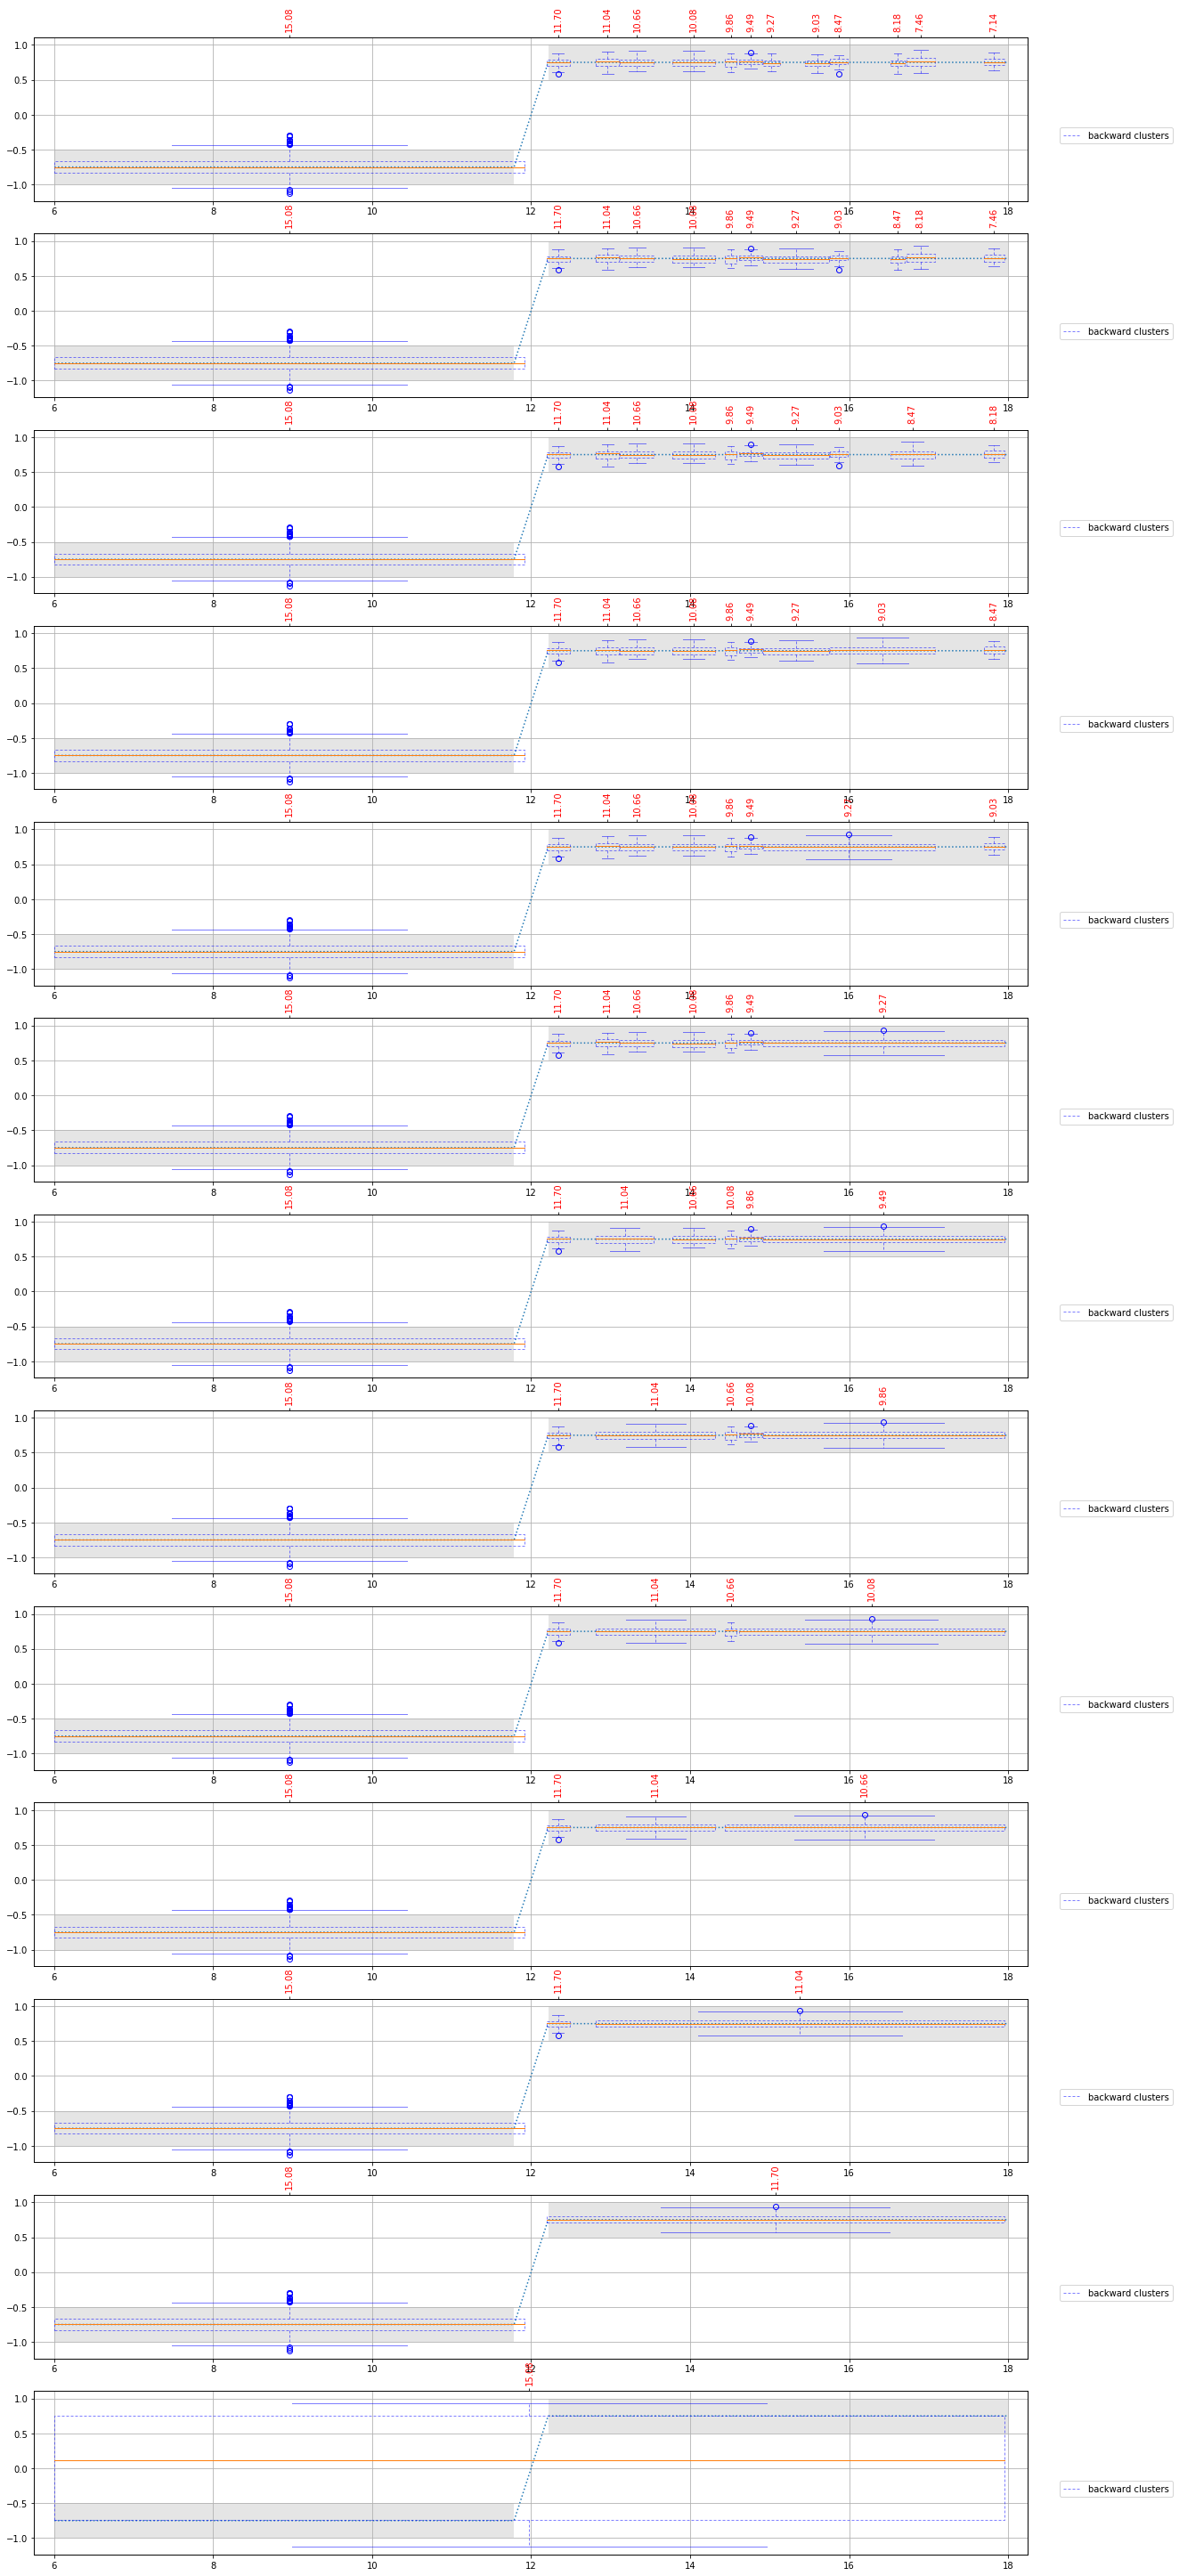

In [580]:
nnn = 13

fig, axs = plt.subplots(nnn,1,figsize=[20,4*nnn])

axs = axs.flatten()

new_clusters_rev2 = clusters_rev.copy()

for n in range(nnn):
    
    ax = axs[n]
    #ax = plot_trajectory(time_arr, raw_arr, noise_arr, None, None, configs['dist_thresh']);
    ax.plot(time_arr, raw_arr, "C0:")
    add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

    ax.set_xlim([5.75,18.25])

    axt = ax.twiny()

    
    gaps = [gap_criterion_2(dist_thresh, time_thresh)(time_arr[::-1],noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]     
    dists = [get_gap_dist(noise_arr[::-1],c1,c2) for c1, c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:])]

    gaps_add = np.array([100*int(not g) for g in gaps])
    dists_add = np.array(dists)+gaps_add

    min_index = np.argmin(dists_add)

    new_clusters_rev2 = merge_cluster_pair(new_clusters_rev2, min_index).copy()
    
    for c1,c2 in zip(new_clusters_rev2[:-1],new_clusters_rev2[1:]):

        gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr[::-1], noise_arr[::-1], time_thresh)

        print(f"{gtime:5.3f}, {allowed:5.3f}", 
              gtime>allowed, 
              f"\t{np.median(noise_arr[::-1][c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[::-1][c2]):7.3f}",
              f"\t{abs(np.median(noise_arr[::-1][c1] - x_med)):7.3f} {abs(np.median(noise_arr[::-1][c2] - x_med)):7.3f}")
    print('\n\n')   
    axt = get_cluster_boxplot(new_clusters_rev2, time_arr, noise_arr, axt, **kwargs_unfilled)


    for label in axt.get_xticklabels():
        label.set_rotation(90)
    axt.set_xticklabels(labels, visible=True, color='red')
    axt.set_xlim(ax.get_xlim())

    ax.grid()
    #ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);    


In [513]:
[gap_criterion_2(dist_thresh, time_thresh)(time_arr,noise_arr,c1,c2) for c1, c2 in zip(new_clusters_2[:-1],new_clusters_2[1:])]  

[]

In [514]:
for c1,c2 in zip(new_clusters_2[:-1],new_clusters_2[1:]):
    
    gtime, allowed, x_med = get_intercluster_metrics(c1, c2, time_arr, noise_arr, time_thresh)
    
    print(f"{gtime:5.3f}, {allowed:5.3f}", 
          gtime>allowed, 
          f"\t{np.median(noise_arr[c1]):7.3f} {x_med:7.3f} {np.median(noise_arr[c2]):7.3f}", 
          f"\t{abs(np.median(noise_arr[c1])-x_med):7.3f} {abs(np.median(noise_arr[c2])-x_med):7.3f}")

In [273]:
cbase = new_clusters[-2][0]+10

In [274]:
clusters2 = get_clusters_rev(time_arr[cbase:], noise_arr[cbase:], dist_thresh, time_thresh)
clusters2 = [[c + cbase for c in c_inner] for c_inner in clusters2]

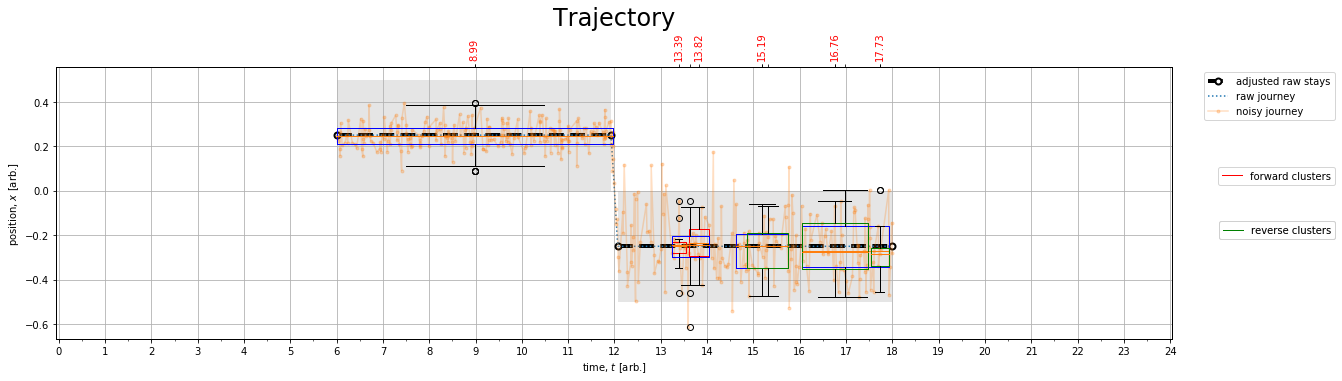

In [275]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);


bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, new_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='blue'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1)



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters2)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='green'), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [60]:
prec, rec, conmat = eval_synth_data(segments, time_arr, new_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.944
 0.944
[[ 34   6]
 [  6 101]]


In [61]:
prec, rec, conmat = eval_synth_data(segments, time_arr, clusters2)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.947
 0.505
[[37  3]
 [53 54]]


In [41]:
configs['count_thresh'] = 10

In [46]:
from stay_classification.box_classifier.box_classify import box_classifier_core
from stay_classification.box_classifier.box_method import get_mask, make_box,get_directional_indices, extend_edge

In [48]:
def get_iqr(data):
    
    q25 = np.quantile(data, 0.25, interpolation='lower')
    q75 = np.quantile(data, 0.75, interpolation='higher')
    return abs(q75 - q25)

In [42]:
def extend_cluster(t_arr, x_arr, cluster, configs, verbose=False):
    
    results = extend_edge(t_arr, x_arr, cluster[-1], cluster[0], [x_arr[cluster].mean()], configs, verbose)

    cluster += results[1]

    results = extend_edge(t_arr, x_arr, cluster[0], cluster[-1], [x_arr[cluster].mean()], configs, verbose)

    cluster = results[1] + cluster

    return cluster

In [43]:
def intersecting_bounds(a1,a2,b1,b2):
    
    return (((a1 >= b1) & (a1 <= b2)) | 
            ((a2 >= b1) & (a2 <= b2)) | 
            ((b1 >= a1) & (b1 <= a2)) | 
            ((b2 >= a1) & (b2 <= a2)))    

inter_bounds = lambda p1, p2: intersecting_bounds(p1[0],p1[-1],p2[0],p2[-1])

In [44]:
def extend_clusters(t_arr, x_arr, clusters, configs, verbose=False):
    
    from stay_classification.box_classifier.box_method import extend_edge

    new_clusters = [extend_cluster(t_arr, x_arr, clusters[0].copy(), configs, verbose)]
    
    for clust in clusters[1:]:
        
        c = extend_cluster(t_arr, x_arr, clust.copy(), configs, verbose)
        
        # check the IQR is within the allowed threshold
        dist_criterion = False
        if get_iqr(x_arr[c])<2*dist_thresh:
            dist_criterion = True
            
        c_last = new_clusters[-1]            
        
        # Check if new cluster overlaps with the previous one
        embed_criterion = False
        if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)        
        
        print(f"[{ clust[0]:4d},{ clust[-1]:4d}]," + "\t"\
              f"{t_arr[clust[0]]:6.3f}...{t_arr[clust[-1]]:6.3f}" + "\t"\
              f"{x_arr[clust].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[clust]):6.3f}," + "\t\t\t"\
              f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
              f"{t_arr[c[0]]:6.3f}...{t_arr[c[-1]]:6.3f}" + "\t"\
              f"{x_arr[c].mean():6.3f}," + "\t"\
              f"{get_iqr(x_arr[c]):6.3f},", \
              dist_criterion, embed_criterion)
        
        
        # check the IQR is within the allowed threshold
        dist_criterion0 = False
        if get_iqr(x_arr[clust])<2*dist_thresh:
            dist_criterion0 = True
                    
        # Check if new cluster overlaps with the previous one
        embed_criterion0 = False
        if len(new_clusters)>0:
            embed_criterion0 = inter_bounds(clust,c_last) 
            
        if dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        elif dist_criterion0 & (not embed_criterion0) & (get_iqr(x_arr[clust]) < get_iqr(x_arr[c])):
            new_clusters.append(clust)
        '''if len(new_clusters)>0:
            embed_criterion = inter_bounds(c,c_last)
            print(f"[{ c[0]:4d},{ c[-1]:4d}]," + "\t"\
                  f"[{c_last[0]:4d},{c_last[-1]:4d}]")

        # ... if there is an overlap, get the one with the smaller IQR
        # ... 1. remove last, append new if dist_crit == True
        if dist_criterion & embed_criterion:
            if get_iqr(noise_arr[c])<get_iqr(noise_arr[c_last]):
                new_clusters[-1] = c       
            else:
                pass
        # ... if no overlap and dist_crit == True, append
        elif dist_criterion & (not embed_criterion):
            new_clusters.append(c)
        else:
            pass'''
    
    return new_clusters

In [49]:
ext_clusters = extend_clusters(time_arr, noise_arr, clusters, configs)

[  59,  92],	11.470...12.518	 0.990,	 0.073,			[  58, 109],	11.421...13.030	 0.607,	 0.717, False True
[ 111, 142],	13.097...13.958	-0.018,	 0.104,			[ 110, 146],	13.057...13.996	 0.180,	 0.317, True False


In [50]:
len(ext_clusters)

2

In [51]:
c = ext_clusters[0]
print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")
for n, c in enumerate(ext_clusters[1:]):
    
    print(f"[{c[0]:4d},{c[-1]:4d}] = {noise_arr[c].mean():>6.3f}, {get_iqr(noise_arr[c]):>6.3f},")

[   0,  67] =  0.266,  0.477,
[ 110, 146] =  0.180,  0.317,


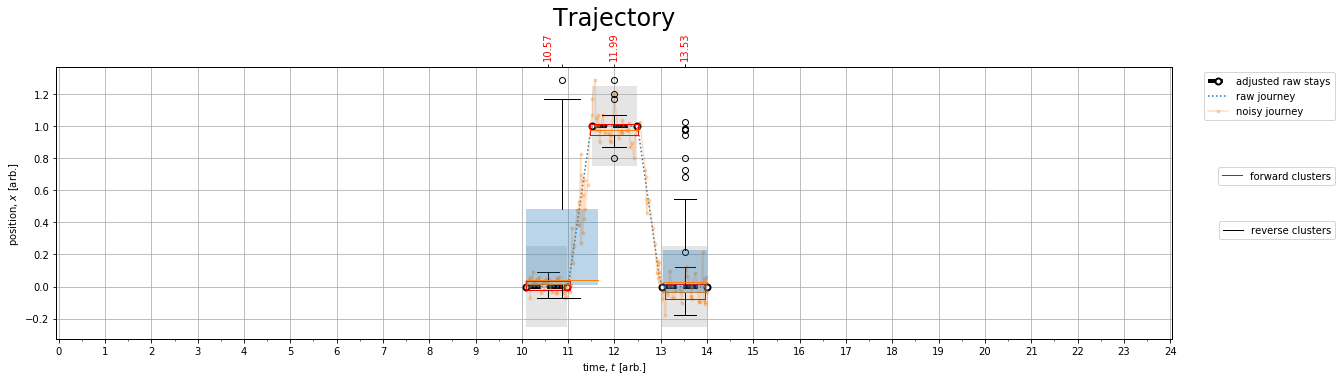

In [52]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)

#ax.set_xlim([21,24])
bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, clusters)

axt = ax.twiny()
_ = axt.boxplot(bp_data, labels=labels, positions=positions, boxprops=dict(color='red'), widths=widths)   

for label in axt.get_xticklabels():
    label.set_rotation(90)
axt.set_xticklabels(labels, visible=True, color='red')


axt.set_xlim(ax.get_xlim())
axt.legend(['forward clusters'], bbox_to_anchor=(1.15, 0.6), loc='center right', ncol=1);



bp_data, labels, positions, widths = get_boxplot_quants(time_arr, noise_arr, ext_clusters)

axt = ax.twiny()
labels = list(map(lambda x: f"{x:.2f}", positions))
_ = axt.boxplot(bp_data, labels=labels, positions=positions, patch_artist=True, boxprops=dict(color='cyan',alpha=0.3, linewidth=0 ), widths=widths)
axt.legend(['reverse clusters'], bbox_to_anchor=(1.15, 0.4), loc='center right', ncol=1);

for label in axt.get_xticklabels():
    label.set_rotation(90)
    
axt.set_xticklabels(labels, visible=False)

axt.set_xlim(ax.get_xlim())
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

**Notes**
* extend clusters (aka the box method) fails: it captures too much and skews to a new box which is outside the preferred region.

In [62]:
prec, rec, conmat = eval_synth_data(segments, time_arr, ext_clusters)
print(f"{prec:6.3f}")
print(f"{ rec:6.3f}")
print(conmat)

 0.790
 0.776
[[18 22]
 [24 83]]


### Refinement with `box_method`

In [48]:
from collections import Counter

In [49]:
def sample_times(indices,frac=0.8):
    return np.sort(np.random.choice(np.array(indices),int(frac*len(indices)), replace=False)).tolist()
    

In [50]:
configs['slope_time_thresh'] = 0.05
configs['slope_thresh'] = abs(dist_thresh/time_thresh)
configs['count_thresh'] = 10
configs['dist_thresh'] = 0.125

start_ind, last_ind = clusters[0][0], clusters[0][-1]

init_pairs = []
final_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    indices = sample_times(range(len(time_arr)),0.99)
    
    start_ind, last_ind, mean, keep = box_classifier_core(time_arr[indices], noise_arr[indices], start_ind, last_ind, timepoint, init_pairs, configs, False)

    if keep:
        final_pairs.append((start_ind, last_ind))
    else:
        continue
    init_pairs.append([cluster[0], cluster[-1]])
    
final_pairs = list(set(final_pairs))
final_pairs

[(218, 687),
 (217, 688),
 (102, 167),
 (117, 181),
 (177, 224),
 (218, 688),
 (219, 689),
 (656, 853),
 (1, 157),
 (1, 158),
 (570, 786)]

In [51]:
mid_pairs = []

for cluster in clusters:
    
    timepoint = time_arr[cluster].mean()
    
    # Get a box for a given timepoint
    mean, start_ind, last_ind = make_box(time_arr, noise_arr, timepoint, configs, False)
            
    mid_pairs.append([start_ind, last_ind,])

mid_pairs

[[1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [1, 169],
 [94, 182],
 [109, 192],
 [170, 236],
 [212, 706],
 [212, 706],
 [212, 706],
 [212, 711],
 [569, 805],
 [654, 863]]

`for m in range(len(final_pairs)):
    for n in range(m,len(final_pairs)):
        s1 = set(list(range(final_pairs[m][0],final_pairs[m][1]+1)))
        s2 = set(list(range(final_pairs[n][0],final_pairs[n][1]+1)))
        print(s1.isdisjoint(s2))`

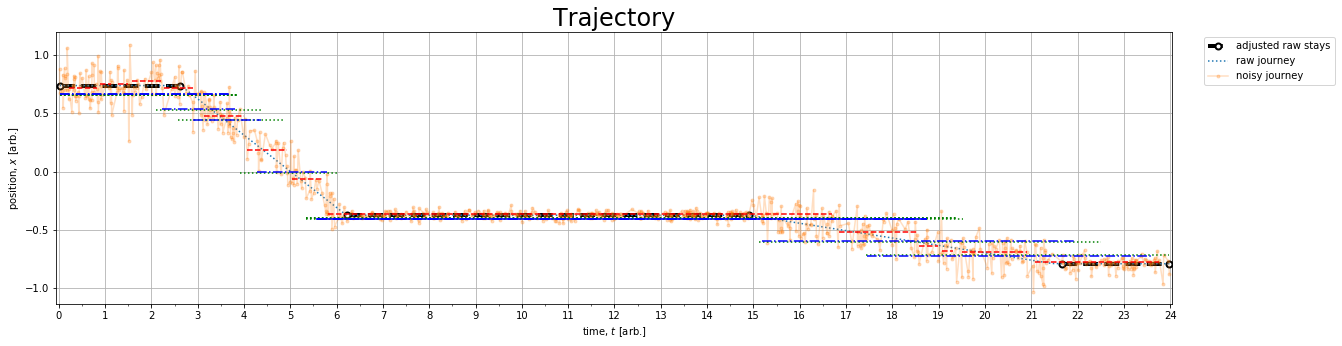

In [52]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])+.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')

for pair in mid_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:')
    
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])-.01
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [53]:
pairs_dur = {}
for p in final_pairs:
    dt = time_arr[p[-1]]-time_arr[p[0]]
    
    pairs_dur[tuple(p)] = dt

In [54]:
pairs_dur = {k: v for k, v in sorted(pairs_dur.items(), key=lambda item: item[1], reverse=True)}

In [55]:
pairs_dur

{(217, 688): 13.195833333333335,
 (218, 688): 13.172777777777778,
 (218, 687): 13.16472222222222,
 (219, 689): 13.130555555555555,
 (570, 786): 6.786111111111113,
 (656, 853): 6.184166666666666,
 (1, 158): 3.6602777777777775,
 (1, 157): 3.658888888888889,
 (102, 167): 1.5597222222222222,
 (177, 224): 1.4944444444444445,
 (117, 181): 1.481666666666667}

### Shifting boxes

In [56]:
from synthetic_data.trajectory import get_stay_indices

true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [57]:
final_pairs = sorted(final_pairs, key = lambda x: x[0])

In [58]:
def get_box_indices(arr, lower, upper):
    return np.where(((arr > lower) & (arr < upper)))

In [64]:
def shift_box(t_arr, x_arr, dist_thresh=None):

    def meth(pair, shift):
        
        x_arr_ = noise_arr[pair[0]:pair[1]+1]
        t_arr_ = time_arr[pair[0]:pair[1]+1]

        mean_ = x_arr_.mean()

        t0,t1 = t_arr_[0],t_arr_[-1]    

        shift = (t1-t0)/8
        mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
        mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

        x_arr_n = x_arr_[mask_n]
        t_arr_n = t_arr_[mask_n]
        x_arr_p = x_arr_[mask_p]  
        t_arr_p = t_arr_[mask_p]        

        mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
        mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)       
        
        #return abs(x_arr_[mean_mask_n].mean()-mean_), abs(x_arr_[mean_mask_p].mean()-mean_)
        return (abs(x_arr_n[mean_mask_n].mean()-mean_) < 0.025) & (abs(x_arr_p[mean_mask_p].mean()-mean_) < 0.025)
    
    
    return meth

In [65]:
len(final_pairs)

11

In [66]:
last_pairs = []
n=0
for pair in final_pairs:
    cond = shift_box(time_arr, noise_arr, dist_thresh)(pair, time_thresh/2)
    if cond: last_pairs.append(pair)
    print(n,pair, cond)
    n+=1

0 (1, 157) False
1 (1, 158) False
2 (102, 167) True
3 (117, 181) True
4 (177, 224) True
5 (217, 688) True
6 (218, 687) True
7 (218, 688) True
8 (219, 689) True
9 (570, 786) True
10 (656, 853) True


0.7095720555240634 0.6743629215779573 0.676439600659611


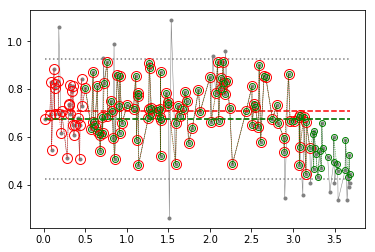

In [67]:
pair = final_pairs[1]

shift = time_thresh/2

x_arr_ = noise_arr[pair[0]:pair[1]+1]
t_arr_ = time_arr[pair[0]:pair[1]+1]

mean_ = x_arr_.mean()

t0,t1 = t_arr_[0],t_arr_[-1]    

shift = (t1-t0)/8
mask_n = get_box_indices(t_arr_, t_arr_[0]-shift, t_arr_[-1]-shift)
mask_p = get_box_indices(t_arr_, t_arr_[0]+shift, t_arr_[-1]+shift)

x_arr_n = x_arr_[mask_n]
t_arr_n = t_arr_[mask_n]
x_arr_p = x_arr_[mask_p]  
t_arr_p = t_arr_[mask_p]        

mean_mask_n = get_box_indices(x_arr_n, mean_-dist_thresh, mean_+dist_thresh)
mean_mask_p = get_box_indices(x_arr_p, mean_-dist_thresh, mean_+dist_thresh)   

plt.plot(t_arr_, x_arr_, '.-', color='gray', lw=0.5)

plt.plot([t_arr_[0],t_arr_[-1]],[mean_,mean_], "--", color='gray', markersize=1)
plt.plot([t_arr_[0],t_arr_[-1]],[mean_+dist_thresh,mean_+dist_thresh], ":", color='gray')
plt.plot([t_arr_[0],t_arr_[-1]],[mean_-dist_thresh,mean_-dist_thresh], ":", color='gray')

#plt.plot(t_arr_n, x_arr_n, 'ro', markerfacecolor="None")
plt.plot(t_arr_n[mean_mask_n], x_arr_n[mean_mask_n], 'ro:', lw=0.7, markerfacecolor="None", markersize=10)
mean_n = x_arr_n[mean_mask_n].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_n,mean_n], "--", color='r', markersize=1)


plt.plot(t_arr_p[mean_mask_p], x_arr_p[mean_mask_p], 'go:', lw=0.7, markerfacecolor="None", markersize=6)
mean_p = x_arr_p[mean_mask_p].mean()
plt.plot([t_arr_[0],t_arr_[-1]],[mean_p,mean_p], "--", color='g', markersize=1)
#print(abs(mean_p-mean_)<0.01,abs(mean_n-mean_)<0.01)
print(mean_n,mean_,mean_p)

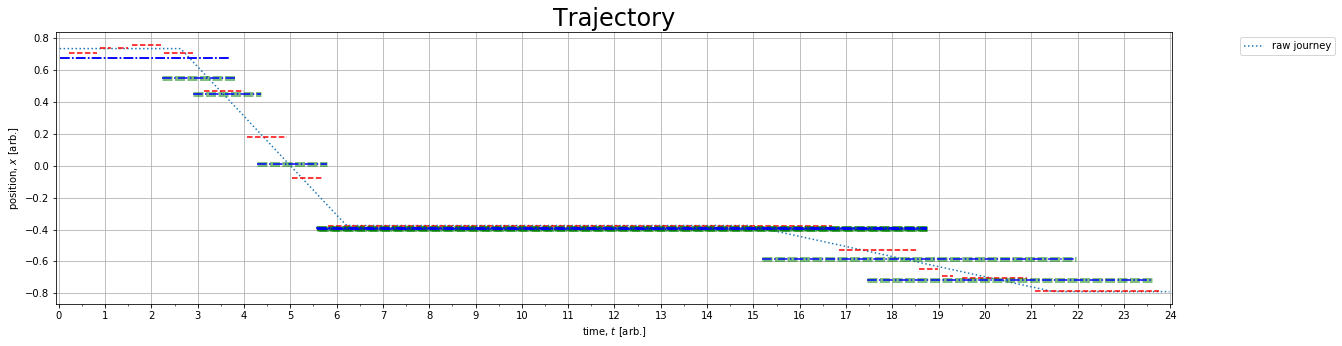

In [68]:
ax = plot_trajectory(time_arr, raw_arr, None, None, None, configs['dist_thresh']);
#'''
for pair in init_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'r--')#'''

for pair in last_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'g:', lw=5, dashes=[2,0.5], alpha=0.5)
    
#'''
for pair in final_pairs:
    t0, t1 = time_arr[pair[0]], time_arr[pair[-1]]
    mean = np.mean(noise_arr[pair[0]:pair[-1]+1])
    #print(t0,t1,mean)
    ax.plot([t0, t1],[mean,mean], 'b-.')#'''
    
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right', ncol=1);

In [1]:
1

1

In [81]:
intersecting_bounds(1,4,2,3), \
intersecting_bounds(2,3,1,4), \
intersecting_bounds(1,3,2,4), \
intersecting_bounds(2,4,1,3), \
intersecting_bounds(1,2,3,4), \
intersecting_bounds(3,4,1,2)


(True, True, True, True, False, False)

In [82]:
new_last_pairs = []

for m in range(len(last_pairs)):

    n = m+1
    while keep_going
        #for n in range(m+1,len(last_pairs)):
        
        print(last_pairs[m], last_pairs[n])
        
        if inter_bounds(last_pairs[m], last_pairs[n]):
            
            l1 = list(range(last_pairs[m][0],last_pairs[m][1]+1))
            l2 = list(range(last_pairs[n][0],last_pairs[n][1]+1))

            len1 = len(l1)
            len2 = len(l2)        

            s1 = set(l1)
            s2 = set(l2)

            ilen1 = len(list(s1.intersection(s2)))
            ilen2 = len(list(s2.intersection(s1)))

            print(last_pairs[m], len1, last_pairs[n], len2,ilen1,ilen2)
            
            if ilen1/len1 > 0.8:
                new_last_pairs.append(last_pairs[m])
        else:
            new_last_pairs.append(last_pairs[m])
        
        n += 1
                            

SyntaxError: invalid syntax (<ipython-input-82-e2bb16c5f24a>, line 6)

In [83]:
new_last_pairs

NameError: name 'new_last_pairs' is not defined